In [1]:
#@title Install Transformers
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.3 MB/s eta 0:00:00


In [2]:
#@title Instantiate the CLIP Seg Model
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [ ]:
#@title Download the refer_train.json file to the local computer, by using ctrl+click on the link; then upload it to  https://drive.google.com/drive/my-drive

# refer_train.json - https://drive.google.com/uc?id=1VCFRajJ4YXPmW5SJg6lS0uKaVAysO61F

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#@title Load the necessary json files from the google drive

import requests
import json

response = requests.get("https://drive.google.com/uc?id=1UmjLJx9BGE9ruOXK1T4iGCYKurY0jNOL")
imgdata = response.json()

response = requests.get("https://drive.google.com/uc?id=1oKPI3pAGL36iELIbZ8xBCRdv8XFjNGyY")
testdata = response.json()
response = requests.get("https://drive.google.com/uc?id=1b59w_IcfpvNfBhraSKw5RfmFHFJ4lIAb")
traindata = response.json()
response = requests.get("https://drive.google.com/uc?id=1-t1Qha7Bu9DKwFxUL9Tt6A6nw6ANtImI")
valdata = response.json()

response = requests.get("https://drive.google.com/uc?id=1o1waJid-D5EvyIoDUyqUbTYofcIPcLZt")
testtaskdata = response.json()
json_file = open('/content/drive/MyDrive/refer_train.json')
#response = requests.get("https://drive.google.com/uc?id=1VCFRajJ4YXPmW5SJg6lS0uKaVAysO61F")
traintaskdata = json.load(json_file)
response = requests.get("https://drive.google.com/uc?id=1Q2HFlss5Y2zLjTydQMWzq6u0iFsGPNnd")
valtaskdata = response.json()



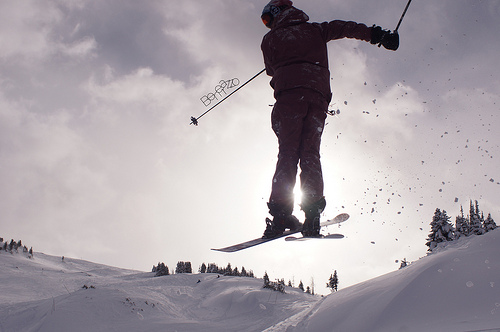

In [36]:
#@title Open a random image from Phrasecut dataset; opens a new image everytime this block is executed
from PIL import Image
import requests
import json
import torch
import random

imagid = random.randint(0,78000)

#url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
url = imgdata[imagid]['url']
imageid = imgdata[imagid]['image_id']
splitdataset=imgdata[imagid]['split']
imagewidth = imgdata[imagid]['width']
imageheight = imgdata[imagid]['height']
#print("Image Id : "+str(imageid))

if (splitdataset == 'test') :
  phrasedata = testdata
  taskdata=testtaskdata
elif (splitdataset == 'train') :
  phrasedata = traindata
  taskdata=traintaskdata
elif (splitdataset == 'val') :
  phrasedata = valdata
  taskdata=valtaskdata


image = Image.open(requests.get(url, stream=True).raw)
image


In [37]:
#@title Prompt with text categories to segment the image

i=0
prompts=[]
found_first_phrase=0
while True:
  if(phrasedata[i]['image_id']==imageid):
      prompts.append(phrasedata[i]['phrase'])
      found_first_phrase=1
  elif (found_first_phrase==1):
    break
  i=i+1

print("text prompts : "+str(prompts))


text prompts : ['leg', 'sky', 'tree', 'pole', 'hill', 'skier']


In [38]:
#@title Input the Image and the text prompt to the CLIP Seg Model
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

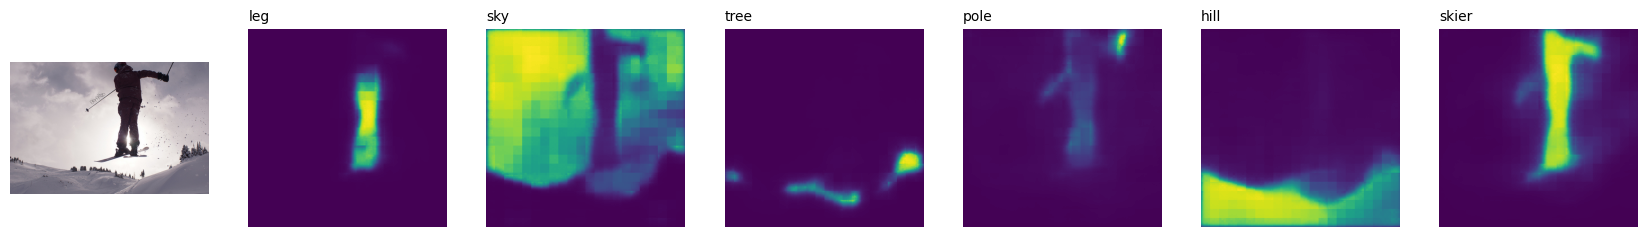

In [39]:
#@title Visualise the output
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

In [40]:
#@title Metrics - IOU and Dice Coefficient

found_first_task=0
i=0
while True:
  if(taskdata[i]['image_id']==imageid):
      break
  i=i+1

firsttaskid=i
sumiou = 0
sumdice = 0
for imgs in range(len(prompts)) :
  firstcorrdfound=0
  minx=500
  miny=500
  maxx=0
  maxy=0
  
  x1=y1=x2=y2=0
  for i in range(352) :
    for j in range(352) :
      if (preds[imgs][0][i][j] > 0) :
        if (j < minx) :
          x1 = j
          minx = j
        if (i < miny) :
          y1 = i
          miny= i
        if(j > maxx) :
            x2 = j
            maxx = j
        if(i > maxy) :
          y2 = i
          maxy = i

  
  maxiou = 0
  max_dice_coeff = 0
  for instance in range(len(taskdata[firsttaskid+imgs]['instance_boxes'])) :
    taskx1=(float(taskdata[firsttaskid+imgs]['instance_boxes'][instance][0])*352.0)/imagewidth
    tasky1=(float(taskdata[firsttaskid+imgs]['instance_boxes'][instance][1])*352.0)/imageheight
    taskwidth=(float(taskdata[firsttaskid+imgs]['instance_boxes'][instance][2])*352.0)/imagewidth
    taskheight=(float(taskdata[firsttaskid+imgs]['instance_boxes'][instance][3])*352.0)/imageheight
    taskx2=taskx1+taskwidth
    tasky2=tasky1+taskheight

    ix1 = max(x1,taskx1) 
    ix2 = min(x2,taskx2)
    iy1 = max(y1,tasky1)
    iy2 = min(y2,tasky2)

    iwidth = ix2 - ix1
    iheight = iy2 - iy1

    predwidth = x2 - x1
    predheight = y2 - y1

    if (iwidth<=0 or iheight<=0) :
      areaofintersection = 0
    else :
      areaofintersection = iwidth * iheight
    #print(areaofintersection)
    areaofunion = (taskwidth * taskheight) + (predwidth * predheight) - areaofintersection
    #print(areaofunion)
    iou = areaofintersection / areaofunion
    if (iou > maxiou) :
      maxiou = iou

    dice_coeff = (2 * areaofintersection) / ((taskwidth * taskheight) + (predwidth * predheight))
    if(dice_coeff > max_dice_coeff) :
      max_dice_coeff = dice_coeff

  if (areaofintersection == 0) :
    print("Phrase: ".ljust(7)+str(prompts[imgs]).ljust(25)+"IOU = No Overlap".ljust(31)+"Dice Coefficient = No Overlap".ljust(25))
  else:
    print("Phrase: ".ljust(7)+str(prompts[imgs]).ljust(25)+"IOU = ".ljust(5)+str(maxiou*100).ljust(25)+"Dice Coefficient = ".ljust(15)+str(max_dice_coeff*100).ljust(10))
  sumiou = sumiou + maxiou
  sumdice = sumdice + max_dice_coeff

print("\n")
print("Mean IOU :"+str((sumiou/len(prompts))*100))
print("Mean Dice Coefficient :"+str((sumdice/len(prompts))*100))


Phrase: leg                      IOU = 81.92628420536721        Dice Coefficient = 90.06536308176871
Phrase: sky                      IOU = 87.27646813721542        Dice Coefficient = 93.20601675728838
Phrase: tree                     IOU = 14.316180256984227       Dice Coefficient = 25.046638585721237
Phrase: pole                     IOU = No Overlap               Dice Coefficient = No Overlap
Phrase: hill                     IOU = 88.07142643246392        Dice Coefficient = 93.65742378105502
Phrase: skier                    IOU = 59.78921039375981        Dice Coefficient = 74.83510337953923


Mean IOU :55.22992823763177
Mean Dice Coefficient :62.801757597562094


In [41]:
#@title Welch T test
import scipy.stats as stats
import numpy as np
from PIL import Image

found_first_task=0
i=0
while True:
  if(taskdata[i]['image_id']==imageid):
      break
  i=i+1

firsttaskid=i
sumiou = 0
sumdice = 0
for imgs in range(len(prompts)) :
  k=l=m=c=d=e=0
  box=[a for a in range(100)]
  box1=[a for a in range(100)]
  out=[a for a in range(100)]
  diff1=[a for a in range(100)]
  diff2=[a for a in range(100)]
  diff3=[a for a in range(100)]
  for i in range(352) :
    for j in range(352) :
      if(preds[imgs][0][i][j] < 0) :
        if(l<50):
          out[l]=preds[imgs][0][i][j]
          l=l+1
        
      if (preds[imgs][0][i][j] > 0) :
        if(k<100):
          box[k]=preds[imgs][0][i][j]
          k=k+1
        
        if(k>=100 and k<150):
          out[k-50]=preds[imgs][0][i][j]
          k=k+1
        
        if(k>=150 and m<100) :
          box1[m]=preds[imgs][0][i][j]
          m=m+1
       
  av1=np.mean(box)
  av3=np.mean(box1)

  while(c<100):
    diff1[c]=abs(box[c]-av1)
    c=c+1
  
  av2=np.mean(out)
  while(d<100):
    diff2[d]=abs(out[d]-av2)
    d=d+1

  while(e<100):
    diff3[e]=abs(box1[e]-av3)
    e=e+1
  
  #print(np.var(diff1,axis=None))
  #print(np.var(diff2,axis=None))  

  #print(av1, av2, av3)
  print("Phrase : "+str(prompts[imgs]))
  print("Welch T Test for two sets of pixel populations both inside of the segmented object : "+str(stats.ttest_ind(np.array(diff1), np.array(diff3), equal_var = False)))
  print("Welch T Test for two sets of pixel populations inside and outside of the segmented object : "+str(stats.ttest_ind(np.array(diff1), np.array(diff2), equal_var = False)))
  print("\n")

Phrase : leg
Welch T Test for two sets of pixel populations both inside of the segmented object : Ttest_indResult(statistic=-1.7764823576180733, pvalue=0.07719019393086203)
Welch T Test for two sets of pixel populations inside and outside of the segmented object : Ttest_indResult(statistic=-169.15117167132033, pvalue=3.326984122519277e-134)


Phrase : sky
Welch T Test for two sets of pixel populations both inside of the segmented object : Ttest_indResult(statistic=0.4441738649321615, pvalue=0.6574257251641284)
Welch T Test for two sets of pixel populations inside and outside of the segmented object : Ttest_indResult(statistic=-7.639924145282616, pvalue=8.305993843651495e-12)


Phrase : tree
Welch T Test for two sets of pixel populations both inside of the segmented object : Ttest_indResult(statistic=0.296025882922104, pvalue=0.7675246309346118)
Welch T Test for two sets of pixel populations inside and outside of the segmented object : Ttest_indResult(statistic=-141.6842921788023, pvalu